In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from pathlib import Path
import numpy as np


# Paths
data_dir_2022 = Path("./2022_data")
report_dir = Path("./reports/cluster_results")
cluster_results_dir = Path("./cluster_results")
aggregated_data_dir = Path("./aggregated_data")
combined_aggregated_data_path = Path("./combined_aggregated_data.csv")
report_dir.mkdir(parents=True, exist_ok=True)
cluster_results_dir.mkdir(parents=True, exist_ok=True)
aggregated_data_dir.mkdir(parents=True, exist_ok=True)

# Columns
all_numerical_cols = ['price_change_count', 'monthly_availability_count', 'quarterly_availability_count', 'monthly_weekend_availability', 
                      'name_c', 'description_c', 'neighborhood_overview_c', 'host_about_c', 'host_response_rate', 'host_acceptance_rate', 
                      'calculated_host_listings_count', 'host_since_days', 'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                      'number_of_reviews', 'reviews_per_month', 'review_scores_rating', 'review_scores_accuracy', 
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
all_categorical_cols = ['host_response_time', 'host_identity_verified', 'host_is_superhost', 'host_has_profile_pic', 'license', 'instant_bookable']

def aggregate_data(city_csv):
    aggregated_file_path = aggregated_data_dir / f'{city_csv.stem}_aggregated.csv'
    if aggregated_file_path.exists():
        print(f"Aggregated data already exists for {city_csv.stem}, skipping aggregation.")
        return pd.read_csv(aggregated_file_path)

    # Load and aggregate data
    data = pd.read_csv(city_csv)
    numerical_data = data.groupby('host_id')[all_numerical_cols].mean()
    categorical_data = data.groupby('host_id')[all_categorical_cols].agg(lambda x: pd.Series.mode(x).iloc[0])
    aggregated_data = pd.concat([numerical_data, categorical_data], axis=1).reset_index()
    aggregated_data['city'] = city_csv.stem
    aggregated_data.to_csv(aggregated_file_path, index=False)
    print(f"Aggregated and saved data for {city_csv.stem}")
    return aggregated_data

def preprocess_data(combined_data):
    # Preprocess the data
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, all_numerical_cols),
            ('cat', categorical_transformer, all_categorical_cols)
        ])
    data_preprocessed = preprocessor.fit_transform(combined_data)
    
    # Apply PCA
    pca = PCA(n_components=0.95)
    data_reduced = pca.fit_transform(data_preprocessed)
    return data_reduced

def save_city_results(city_name, city_data, labels):
    # Create a copy of the city data to avoid SettingWithCopyWarning
    city_data = city_data.copy()
    
    # Save cluster results for the city
    city_data['cluster_label'] = labels
    result_path = cluster_results_dir / f'{city_name}_cluster_results.csv'
    city_data.to_csv(result_path, index=False)
    print(f"Saved cluster results for {city_name}")

def apply_dbscan(preprocessed_data, eps_value, min_samples_value):
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    labels = dbscan.fit_predict(preprocessed_data)
    return labels

def add_tool_use_column(city_data):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    city_data_copy = city_data.copy()
    city_data_copy['tool_use'] = (city_data_copy['cluster_label'] >= 1).astype(int)
    return city_data_copy

def process_all_cities():
    city_files = list(data_dir_2022.glob('*.csv'))
    print(f"Total cities to process: {len(city_files)}")

    all_aggregated_data = pd.DataFrame()
    for city_file in city_files:
        city_aggregated_data = aggregate_data(city_file)
        all_aggregated_data = pd.concat([all_aggregated_data, city_aggregated_data], ignore_index=True)

    print("Preprocessing data...")
    preprocessed_data = preprocess_data(all_aggregated_data)

    print("Applying DBSCAN...")
    eps_value = 3 # 
    min_samples_value = 30  # I have around 30 variables in cluster
    labels = apply_dbscan(preprocessed_data, eps_value, min_samples_value)
    all_aggregated_data['cluster_label'] = labels

    # Calculate tool_use based on cluster_label
    all_aggregated_data = add_tool_use_column(all_aggregated_data)

    # One-hot encode categorical columns
    onehot_encoder = OneHotEncoder()
    onehot_encoded = onehot_encoder.fit_transform(all_aggregated_data[all_categorical_cols]).toarray()
    onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(all_categorical_cols))
    
    # Combine original data with one-hot encoded categorical data
    all_aggregated_data_extended = pd.concat([all_aggregated_data.reset_index(drop=True), onehot_encoded_df], axis=1)

    # Perform correlation analysis on the extended DataFrame
    combined_data_for_correlation = pd.concat([all_aggregated_data_extended[all_numerical_cols], onehot_encoded_df], axis=1)
    combined_data_for_correlation['cluster_label'] = all_aggregated_data_extended['cluster_label']

    # Save results for each city and combined data
    for city in all_aggregated_data['city'].unique():
        city_data = all_aggregated_data[all_aggregated_data['city'] == city]
        city_labels = city_data['cluster_label']
        city_data = add_tool_use_column(city_data)  # Add tool_use calculation here
        save_city_results(city, city_data, city_labels)

    all_aggregated_data_extended.to_csv(combined_aggregated_data_path, index=False)
    print(f"Combined aggregated data saved to {combined_aggregated_data_path}")

# Execute the process
process_all_cities()




Total cities to process: 109
Aggregated data already exists for final_2022_amsterdam, skipping aggregation.
Aggregated data already exists for final_2022_antwerp, skipping aggregation.
Aggregated data already exists for final_2022_asheville, skipping aggregation.
Aggregated data already exists for final_2022_athens, skipping aggregation.
Aggregated data already exists for final_2022_austin, skipping aggregation.
Aggregated data already exists for final_2022_bangkok, skipping aggregation.
Aggregated data already exists for final_2022_barcelona, skipping aggregation.
Aggregated data already exists for final_2022_barossa-valley, skipping aggregation.
Aggregated data already exists for final_2022_barwon-south-west-vic, skipping aggregation.
Aggregated data already exists for final_2022_belize, skipping aggregation.
Aggregated data already exists for final_2022_bergamo, skipping aggregation.
Aggregated data already exists for final_2022_berlin, skipping aggregation.
Aggregated data already 

KeyboardInterrupt: 

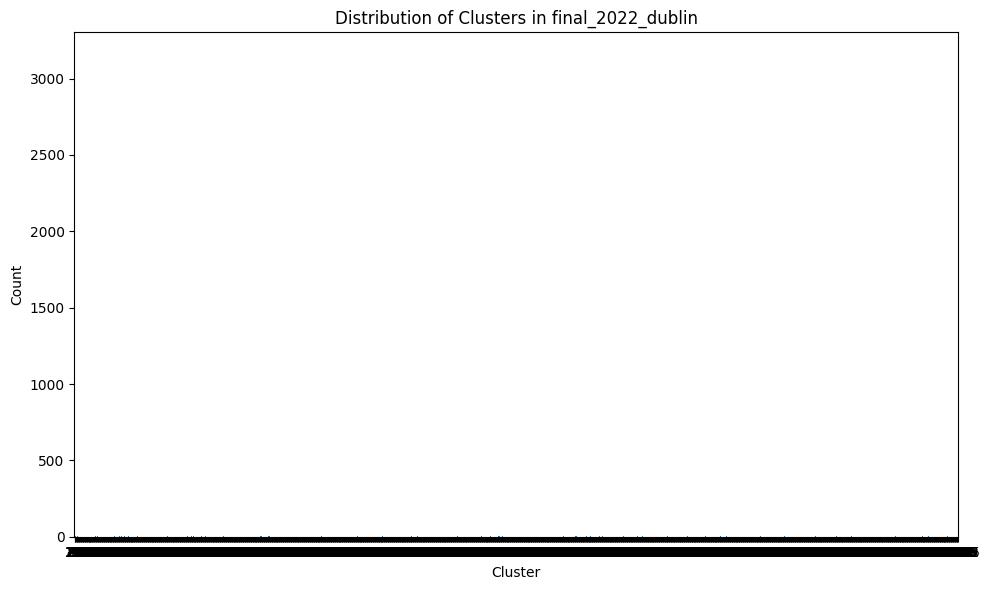

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
   
# Paths
cluster_results_dir = Path("./cluster_results")
cluster_distribution_dir = Path("./reports/cluster_distribution")
tool_use_distribution_dir = Path("./reports/tool_use_distribution")

# Create the directory if it doesn't exist
cluster_distribution_dir.mkdir(parents=True, exist_ok=True)
tool_use_distribution_dir.mkdir(parents=True, exist_ok=True)

# Combine all cluster result files into one DataFrame
all_cluster_results = pd.DataFrame()

for file in cluster_results_dir.glob('*.csv'):
    city_data = pd.read_csv(file)
    city_name = file.stem.replace("_cluster_results", "")
    city_data['city'] = city_name
    all_cluster_results = pd.concat([all_cluster_results, city_data])

# Loop through each city to create a separate plot
for city in all_cluster_results['city'].unique():
    # Filter the DataFrame for the current city
    city_data = all_cluster_results[all_cluster_results['city'] == city]

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.countplot(data=city_data, x='cluster_label')
    plt.title(f'Distribution of Clusters in {city}')
    plt.ylabel('Count')
    plt.xlabel('Cluster')
    plt.tight_layout()

    # Save the plot with the city name in the filename
    plot_file = cluster_distribution_dir / f'cluster_distribution_{city}.png'
    plt.savefig(plot_file, format='png')
    plt.close()

for city in all_cluster_results['city'].unique():
    # Filter the DataFrame for the current city
    city_data = all_cluster_results[all_cluster_results['city'] == city]

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.countplot(data=city_data, x='tool_use')
    plt.title(f'Distribution of Tool Usage in {city}')
    plt.ylabel('Count')
    plt.xlabel('Cluster')
    plt.tight_layout()

    # Save the plot with the city name in the filename
    plot_file = tool_use_distribution_dir / f'tool_use_distribution_{city}.png'
    plt.savefig(plot_file, format='png')
    plt.close()


In [ ]:
import pandas as pd
import os
import gc

# Directory paths
data_dir = './2023_data/'
cluster_dir = './tool_use_results/'
output_dir = './2023_final_data/'
report_dir = './reports/removed_host_id/'

# Create necessary directories if they don't exist
for directory in [output_dir, report_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to normalize city names
def normalize_city_name(city_name):
    return city_name.lower().replace('-', '').replace('_', '').replace(' ', '')

# Load and deduplicate cluster data
cluster_data = {}
for cluster_file in os.listdir(cluster_dir):
    if cluster_file.startswith('final_2022_'):
        city = cluster_file.replace('final_2022_', '').replace('_cluster_results.csv', '')
        city_normalized = normalize_city_name(city)
        cluster_df = pd.read_csv(os.path.join(cluster_dir, cluster_file))
        cluster_data[city_normalized] = cluster_df[['host_id', 'tool_use']]

# Columns to keep in the final output
columns_to_keep = ['listing_id', 'date', 'available', 'price_change_count', 'change_in_availability', 'month', 
                'quarter', 'monthly_availability_count', 'quarterly_availability_count', 'monthly_weekend_availability',
                'price_usd', 'price','name_c', 'description_c', 'neighborhood_overview_c', 'is_weekend', 'minimum_nights', 'maximum_nights', 
                'host_listings_count_airbnb', 'host_id', 'host_since', 'host_about_c', 'host_response_time', 'host_response_rate', 
                'host_acceptance_rate', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 
                'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities_count', 
                'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 
                'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 
                'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
        ]

# Process each data file
for data_file in os.listdir(data_dir):
    if data_file.startswith('final_2023_'):
        city = data_file.replace('final_2023_', '').replace('.csv', '')
        city_normalized = normalize_city_name(city)
        
        if city_normalized in cluster_data:
            print(f"Processing city: {city}")
            data_df = pd.read_csv(os.path.join(data_dir, data_file), low_memory=False)

            missing_host_ids = set()
            merged_data = data_df.merge(cluster_data[city_normalized], on='host_id', how='left')
            missing_host_ids.update(data_df[~data_df['host_id'].isin(cluster_data[city_normalized]['host_id'])]['host_id'])

            # Compute actual_tool_use as the product of tool_use and available
            merged_data['actual_tool_use'] = merged_data['tool_use'] * merged_data['available']

            # Remove rows with missing host_id and keep only specified columns
            cleaned_data = merged_data.dropna(subset=['tool_use'])
            cleaned_data = cleaned_data[columns_to_keep + ['actual_tool_use']]  # Add actual_tool_use to the columns to keep

            # Write cleaned data to output file
            output_file = os.path.join(output_dir, f'final_2023_{city}.csv')
            cleaned_data.to_csv(output_file, index=False)

            # Writing missing host_id report
            report_file = os.path.join(report_dir, f'{city}_deleted_host_ids.txt')
            with open(report_file, 'w') as f:
                for host_id in missing_host_ids:
                    f.write(str(host_id) + '\n')

            gc.collect()

        else:
            print(f"No cluster data for city: {city}")

print("All files have been processed.")
